## RNN

### Import libraries

In [1]:
!pip install optuna

import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Dropout, LSTM
from tensorflow.keras.models import Model
import optuna
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.5 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### Preprocessing module

In [2]:
# Load the data
train_url = 'https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv'
test_url = 'https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv'

train_df = pd.read_csv(train_url, header=None)
test_df = pd.read_csv(test_url, header=None)
train_df.columns = ['Class Index', 'Title', 'Description']
test_df.columns = ['Class Index', 'Title', 'Description']

In [3]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower() # convert text to lowercase
    text = re.sub(r'\b(u\.s\.|us)\b', 'usa', text, flags=re.IGNORECASE)  # replace "U.S." or "US" with "usa"
    text = re.sub(r'<[^>]+>', '', text)  # remove HTML tags
    text = re.sub(r'&\w+;', '', text)  # remove HTML entities
    text = re.sub(r'[^a-z\s]', '', text)  # remove numbers and punctuation (keep only letters and spaces)
    words = text.split()
    words = [word for word in words if word not in stop_words] # remove stop-words, tokenization
    words = [lemmatizer.lemmatize(word) for word in words] # lemmatization
    return ' '.join(words) # combining words into a string

# Apply preprocessing
train_df['clean_text'] = (train_df['Title'] + ' ' + train_df['Description']).apply(preprocess_text)
test_df['clean_text'] = (test_df['Title'] + ' ' + test_df['Description']).apply(preprocess_text)

# Tokenization and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_df['clean_text'])
max_length_titles = max([len(x.split()) for x in train_df['Title']])
max_length_descriptions = max([len(x.split()) for x in train_df['Description']])

X_train_title_pad = pad_sequences(tokenizer.texts_to_sequences(train_df['Title']), maxlen=max_length_titles)
X_test_title_pad = pad_sequences(tokenizer.texts_to_sequences(test_df['Title']), maxlen=max_length_titles)
X_train_description_pad = pad_sequences(tokenizer.texts_to_sequences(train_df['Description']), maxlen=max_length_descriptions)
X_test_description_pad = pad_sequences(tokenizer.texts_to_sequences(test_df['Description']), maxlen=max_length_descriptions)

y_train = train_df['Class Index'].values - 1
y_test = test_df['Class Index'].values - 1

# Download and load GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

# Load GloVe embeddings
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_matrix = np.zeros((5000, 100))
for word, i in tokenizer.word_index.items():
    if i < 5000:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(input_dim=5000, output_dim=100, weights=[embedding_matrix], trainable=False)

--2024-10-29 16:27:45--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-10-29 16:27:46--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-10-29 16:27:46--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

### Basic training module

In [4]:
# Define the baseline model with LSTM layers
title_input = Input(shape=(max_length_titles,), name='title_input')
title_embedding = embedding_layer(title_input)
title_lstm = LSTM(128, return_sequences=False)(title_embedding)

description_input = Input(shape=(max_length_descriptions,), name='description_input')
description_embedding = embedding_layer(description_input)
description_lstm = LSTM(128, return_sequences=False)(description_embedding)

merged = Concatenate()([title_lstm, description_lstm])
dense_1 = Dense(128, activation='relu')(merged)
dense_2 = Dense(64, activation='relu')(dense_1)
output = Dense(4, activation='softmax')(dense_2)

model = Model(inputs=[title_input, description_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=3e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the baseline model
model.fit([X_train_title_pad, X_train_description_pad], y_train, validation_split=0.1,
          epochs=5, batch_size=32, callbacks=[early_stopping], verbose=1)

Epoch 1/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/step - accuracy: 0.7593 - loss: 0.6594 - val_accuracy: 0.8796 - val_loss: 0.3427
Epoch 2/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - accuracy: 0.8809 - loss: 0.3445 - val_accuracy: 0.8865 - val_loss: 0.3235
Epoch 3/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 82s 12ms/step - accuracy: 0.8848 - loss: 0.3299 - val_accuracy: 0.8892 - val_loss: 0.3149
Epoch 4/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - accuracy: 0.8882 - loss: 0.3160 - val_accuracy: 0.8904 - val_loss: 0.3105
Epoch 5/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - accuracy: 0.8928 - loss: 0.3050 - val_accuracy: 0.8904 - val_loss: 0.3070


### Testing Module 1 (Base Model)

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Baseline Test Accuracy: 0.8909
Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      1900
           1       0.94      0.96      0.95      1900
           2       0.86      0.83      0.85      1900
           3       0.85      0.89      0.87      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600



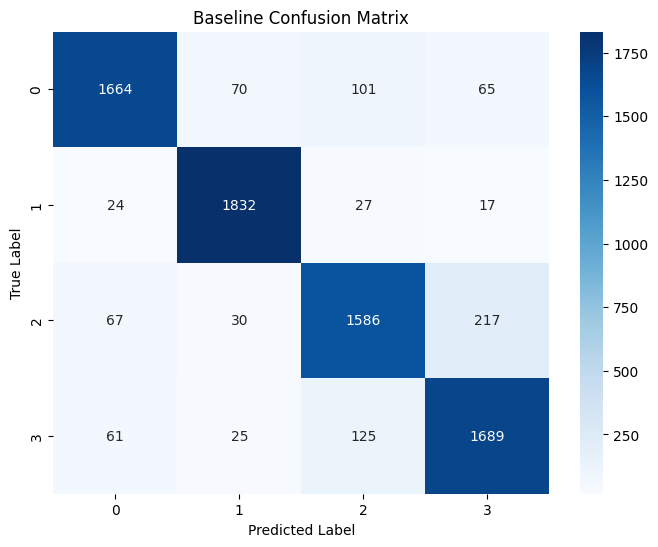

In [5]:
# Evaluate baseline model
y_pred = model.predict([X_test_title_pad, X_test_description_pad])
y_pred_classes = y_pred.argmax(axis=1)

baseline_accuracy = (y_pred_classes == y_test).mean()
print(f'Baseline Test Accuracy: {baseline_accuracy:.4f}')
print("Baseline Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Baseline Confusion Matrix')
plt.show()

### Hyperparameter selection module

In [6]:
def model_builder(trial):
    # Define hyperparameters for optimization
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    lstm_units = trial.suggest_int('lstm_units', 64, 256)
    num_units = trial.suggest_int('num_units', 64, 512)

    # Define model structure with Optuna parameters
    title_input = Input(shape=(max_length_titles,), name='title_input')
    title_embedding = embedding_layer(title_input)
    title_lstm = LSTM(lstm_units, return_sequences=False)(title_embedding)

    description_input = Input(shape=(max_length_descriptions,), name='description_input')
    description_embedding = embedding_layer(description_input)
    description_lstm = LSTM(lstm_units, return_sequences=False)(description_embedding)

    merged = Concatenate()([title_lstm, description_lstm])
    dense_1 = Dense(num_units, activation='relu')(merged)
    dropout_1 = Dropout(dropout_rate)(dense_1)
    output = Dense(4, activation='softmax')(dropout_1)

    model = Model(inputs=[title_input, description_input], outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Objective function for Optuna
def objective(trial):
    model = model_builder(trial)
    model.fit([X_train_title_pad, X_train_description_pad], y_train, validation_split=0.1, epochs=3, batch_size=32, verbose=1)
    _, accuracy = model.evaluate([X_test_title_pad, X_test_description_pad], y_test, verbose=1)
    return accuracy

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)
print("Best Trial:", study.best_trial)

[I 2024-10-29 16:36:06,068] A new study created in memory with name: no-name-d504cf77-6fde-458f-ab8e-7a34fb2b5619


Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 54s 15ms/step - accuracy: 0.8291 - loss: 0.5111 - val_accuracy: 0.8817 - val_loss: 0.3266
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 47s 14ms/step - accuracy: 0.8855 - loss: 0.3287 - val_accuracy: 0.8853 - val_loss: 0.3184
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 83s 14ms/step - accuracy: 0.8918 - loss: 0.3099 - val_accuracy: 0.8862 - val_loss: 0.3072
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8813 - loss: 0.3243


[I 2024-10-29 16:39:47,205] Trial 0 finished with value: 0.8863157629966736 and parameters: {'dropout_rate': 0.1525192891213007, 'learning_rate': 6.050459005943161e-05, 'lstm_units': 214, 'num_units': 113}. Best is trial 0 with value: 0.8863157629966736.


Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 49s 14ms/step - accuracy: 0.8614 - loss: 0.4066 - val_accuracy: 0.8888 - val_loss: 0.3197
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 82s 14ms/step - accuracy: 0.9049 - loss: 0.2782 - val_accuracy: 0.8981 - val_loss: 0.2887
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 82s 14ms/step - accuracy: 0.9152 - loss: 0.2420 - val_accuracy: 0.8934 - val_loss: 0.2988
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9021 - loss: 0.3058


[I 2024-10-29 16:43:59,287] Trial 1 finished with value: 0.9028947353363037 and parameters: {'dropout_rate': 0.2521933277550814, 'learning_rate': 0.004373038367548089, 'lstm_units': 200, 'num_units': 123}. Best is trial 1 with value: 0.9028947353363037.


Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 54s 15ms/step - accuracy: 0.8221 - loss: 0.5233 - val_accuracy: 0.8850 - val_loss: 0.3248
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - accuracy: 0.8820 - loss: 0.3375 - val_accuracy: 0.8856 - val_loss: 0.3124
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 86s 16ms/step - accuracy: 0.8905 - loss: 0.3130 - val_accuracy: 0.8857 - val_loss: 0.3084
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8882 - loss: 0.3214


[I 2024-10-29 16:48:11,295] Trial 2 finished with value: 0.8911842107772827 and parameters: {'dropout_rate': 0.4049785405771394, 'learning_rate': 4.8782164021264176e-05, 'lstm_units': 239, 'num_units': 422}. Best is trial 1 with value: 0.9028947353363037.


Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 51s 14ms/step - accuracy: 0.8555 - loss: 0.4289 - val_accuracy: 0.8675 - val_loss: 0.3689
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 47s 14ms/step - accuracy: 0.8850 - loss: 0.3444 - val_accuracy: 0.8864 - val_loss: 0.3269
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 81s 14ms/step - accuracy: 0.8931 - loss: 0.3191 - val_accuracy: 0.8796 - val_loss: 0.3453
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8926 - loss: 0.3418


[I 2024-10-29 16:51:12,532] Trial 3 finished with value: 0.8928947448730469 and parameters: {'dropout_rate': 0.20027090400315856, 'learning_rate': 0.009547292336372883, 'lstm_units': 189, 'num_units': 184}. Best is trial 1 with value: 0.9028947353363037.


Epoch 1/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 47s 13ms/step - accuracy: 0.8345 - loss: 0.5032 - val_accuracy: 0.8850 - val_loss: 0.3202
Epoch 2/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 82s 13ms/step - accuracy: 0.8874 - loss: 0.3194 - val_accuracy: 0.8813 - val_loss: 0.3231
Epoch 3/3
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 81s 13ms/step - accuracy: 0.8943 - loss: 0.3000 - val_accuracy: 0.8892 - val_loss: 0.3021
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8880 - loss: 0.3133


[I 2024-10-29 16:55:24,270] Trial 4 finished with value: 0.8911842107772827 and parameters: {'dropout_rate': 0.13006954405604848, 'learning_rate': 6.893954727121713e-05, 'lstm_units': 143, 'num_units': 485}. Best is trial 1 with value: 0.9028947353363037.


Best Trial: FrozenTrial(number=1, state=TrialState.COMPLETE, values=[0.9028947353363037], datetime_start=datetime.datetime(2024, 10, 29, 16, 39, 47, 207744), datetime_complete=datetime.datetime(2024, 10, 29, 16, 43, 59, 287459), params={'dropout_rate': 0.2521933277550814, 'learning_rate': 0.004373038367548089, 'lstm_units': 200, 'num_units': 123}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dropout_rate': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'lstm_units': IntDistribution(high=256, log=False, low=64, step=1), 'num_units': IntDistribution(high=512, log=False, low=64, step=1)}, trial_id=1, value=None)


### Testing module 2 (Optimized Model)

Epoch 1/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 51s 14ms/step - accuracy: 0.8645 - loss: 0.3956 - val_accuracy: 0.8880 - val_loss: 0.3107
Epoch 2/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 81s 14ms/step - accuracy: 0.9052 - loss: 0.2787 - val_accuracy: 0.8927 - val_loss: 0.3025
Epoch 3/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 81s 14ms/step - accuracy: 0.9157 - loss: 0.2416 - val_accuracy: 0.8974 - val_loss: 0.2891
Epoch 4/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 81s 14ms/step - accuracy: 0.9250 - loss: 0.2121 - val_accuracy: 0.8937 - val_loss: 0.3120
Epoch 5/5
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 83s 14ms/step - accuracy: 0.9336 - loss: 0.1868 - val_accuracy: 0.8967 - val_loss: 0.3201
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Final Test Accuracy: 0.9014
Final Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.87      0.90      1900
           1       0.95      0.97      0.96      1900
           2       0.85      0.88      0.87      1900
           3       0.87      0

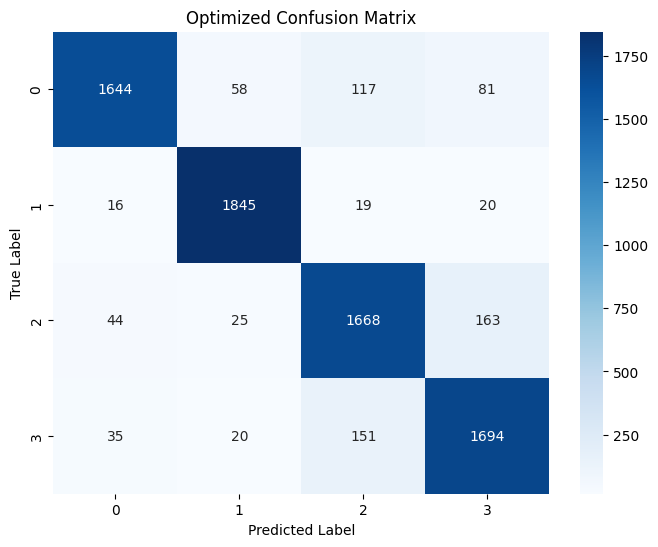

In [7]:
# Load the best model from Optuna optimization
best_trial = study.best_trial
model = model_builder(best_trial)
model.fit([X_train_title_pad, X_train_description_pad], y_train, validation_split=0.1, epochs=5, batch_size=32, verbose=1)

# Evaluate optimized model
y_pred = model.predict([X_test_title_pad, X_test_description_pad])
y_pred_classes = y_pred.argmax(axis=1)

final_accuracy = (y_pred_classes == y_test).mean()
print(f'Final Test Accuracy: {final_accuracy:.4f}')
print("Final Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix for optimized model
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Optimized Confusion Matrix')
plt.show()